In [10]:

!pip install matplotlib scikit-learn



  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------ --------------------------- 2.6/8.1 MB 15.0 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 14.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   --------------- ------------------------ 3.4/8.9 MB 16.7 MB/s eta 0:00:01
   -------------------------------- ------- 7.3/8.9 MB 17.4 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 17.3 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 21.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
  

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Reproducibility
np.random.seed(42)

# Directories
raw_dir = Path('D:/bootcamp_Jinay_Jain/homework/homework7/data/raw')
processed_dir = Path('D:/bootcamp_Jinay_Jain/homework/homework7/data/processed')
raw_dir.mkdir(parents=True, exist_ok=True)
processed_dir.mkdir(parents=True, exist_ok=True)

Data Generation and loading

In [27]:
# Generate synthetic financial data
dates = pd.date_range(start="2023-07-03", end="2023-12-29", freq="B")

# Stock A returns: drift + noise
stock_a = np.random.normal(0.0008, 0.012, size=len(dates))
stock_a[dates < "2023-10-01"] -= 0.001

# Add shock events (simulate volatility spikes)
shock_points = {
    "2023-10-16": 0.15,
    "2023-10-18": -0.17,
    "2023-11-10": -0.13,
    "2023-11-13": 0.20
}
for d, v in shock_points.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    stock_a[idx] = v

# Stock B: correlated with Stock A
stock_b = stock_a * 0.7 + np.random.normal(0, 0.007, size=len(dates))

df = pd.DataFrame({
    "date": dates,
    "stock_a_return": stock_a,
    "stock_b_return": stock_b
})

# Save file
csv_path = raw_dir / 'financial_outliers.csv'
df.to_csv(csv_path, index=False)

# Load data
df = pd.read_csv(csv_path)
df.head()


,date,stock_a_return,stock_b_return
0,2023-07-03,0.005761,-0.006822
1,2023-07-04,-0.001859,-0.000821
2,2023-07-05,0.007572,-0.002136
3,2023-07-06,0.018076,0.015969
4,2023-07-07,-0.003010,-0.008543


Outlier Detection Functions

In [28]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """
    Detect outliers using IQR rule.

    Parameters
    ----------
    series : pd.Series
        Input numeric series.
    k : float
        Multiplier for IQR (default=1.5).

    Returns
    -------
    pd.Series
        Boolean mask where True indicates outlier.
    """
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (series < lower) | (series > upper)


def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """
    Detect outliers using Z-score.

    Parameters
    ----------
    series : pd.Series
        Input numeric series.
    threshold : float
        Z-score threshold (default=3.0).

    Returns
    -------
    pd.Series
        Boolean mask where True indicates outlier.
    """
    mu, sigma = series.mean(), series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold


def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """
    Winsorize a series by capping values at given quantiles.

    Parameters
    ----------
    series : pd.Series
        Input numeric series.
    lower : float
        Lower quantile (default=0.05).
    upper : float
        Upper quantile (default=0.95).

    Returns
    -------
    pd.Series
        Winsorized series.
    """
    lo, hi = series.quantile([lower, upper])
    return series.clip(lower=lo, upper=hi)


Apply Outlier Detection

In [29]:
target_col = 'stock_a_return'

df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col])

print("Outlier fraction:")
print(df[['outlier_iqr', 'outlier_z']].mean())


Outlier fraction:
outlier_iqr    0.053846
outlier_z      0.030769
dtype: float64


Visualizations (Before/After)

C:\Users\jinay\AppData\Local\Temp\ipykernel_6748\2562613601.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[target_col], df.loc[~df['outlier_iqr'], target_col]], labels=['All', 'Filtered'])


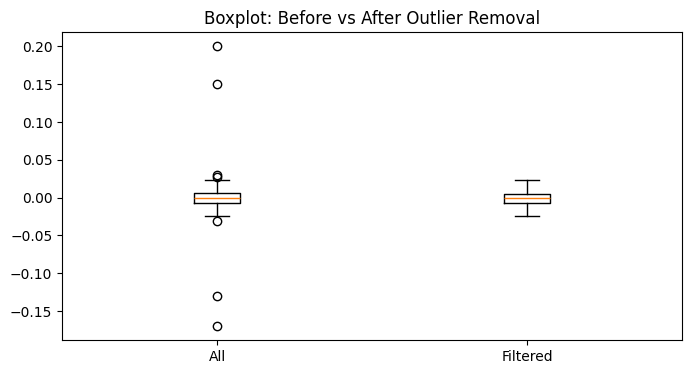

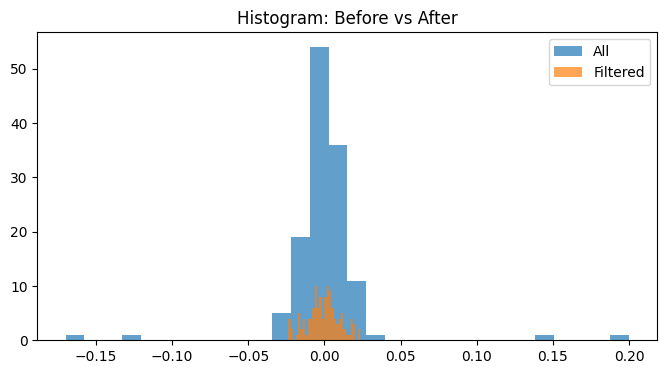

In [30]:
# Boxplot before and after IQR filtering
plt.figure(figsize=(8,4))
plt.boxplot([df[target_col], df.loc[~df['outlier_iqr'], target_col]], labels=['All', 'Filtered'])
plt.title('Boxplot: Before vs After Outlier Removal')
plt.show()

# Histogram
plt.figure(figsize=(8,4))
plt.hist(df[target_col], bins=30, alpha=0.7, label='All')
plt.hist(df.loc[~df['outlier_iqr'], target_col], bins=30, alpha=0.7, label='Filtered')
plt.title('Histogram: Before vs After')
plt.legend()
plt.show()


Sensitivity Analysis (Summary Stats)

In [31]:
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = winsorize_series(df[target_col]).describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat({
    'all': summ_all,
    'filtered_iqr': summ_filtered,
    'winsorized': summ_w
}, axis=1)
comp


,all,filtered_iqr,winsorized
mean,-0.000029,-0.000656,-0.000541
median,-0.000079,-0.000093,-0.000079
std,0.031073,0.010561,0.011158


Regression Analysis & Plots

In [32]:
X_all = df[['stock_a_return']].to_numpy()
y_all = df['stock_b_return'].to_numpy()

X_filtered = df.loc[~df['outlier_iqr'], ['stock_a_return']].to_numpy()
y_filtered = df.loc[~df['outlier_iqr'], 'stock_b_return'].to_numpy()

model_all = LinearRegression().fit(X_all, y_all)
model_flt = LinearRegression().fit(X_filtered, y_filtered)

mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

results = pd.DataFrame({
    'slope': [model_all.coef_[0], model_flt.coef_[0]],
    'intercept': [model_all.intercept_, model_flt.intercept_],
    'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
    'mae': [mae_all, mae_flt]
}, index=['all', 'filtered_iqr'])
results


,slope,intercept,r2,mae
all,0.695154,0.000580,0.904201,0.005596
filtered_iqr,0.604598,0.000597,0.454069,0.005605


Regression Scatter Plots

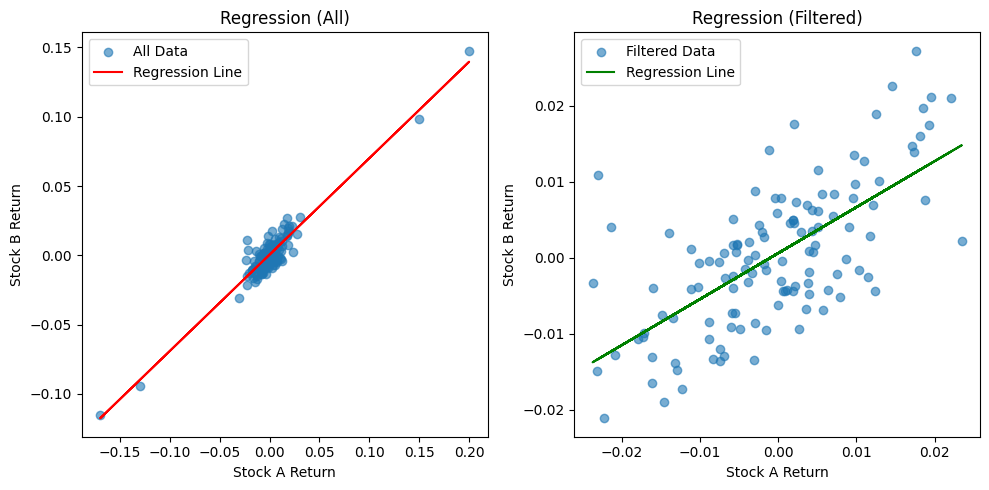

In [33]:
# Regression plots
plt.figure(figsize=(10,5))

# Before outlier removal
plt.subplot(1,2,1)
plt.scatter(X_all, y_all, alpha=0.6, label='All Data')
plt.plot(X_all, model_all.predict(X_all), color='red', label='Regression Line')
plt.title('Regression (All)')
plt.xlabel('Stock A Return'); plt.ylabel('Stock B Return')
plt.legend()

# After outlier removal
plt.subplot(1,2,2)
plt.scatter(X_filtered, y_filtered, alpha=0.6, label='Filtered Data')
plt.plot(X_filtered, model_flt.predict(X_filtered), color='green', label='Regression Line')
plt.title('Regression (Filtered)')
plt.xlabel('Stock A Return'); plt.ylabel('Stock B Return')
plt.legend()

plt.tight_layout()
plt.show()


Residual Plots

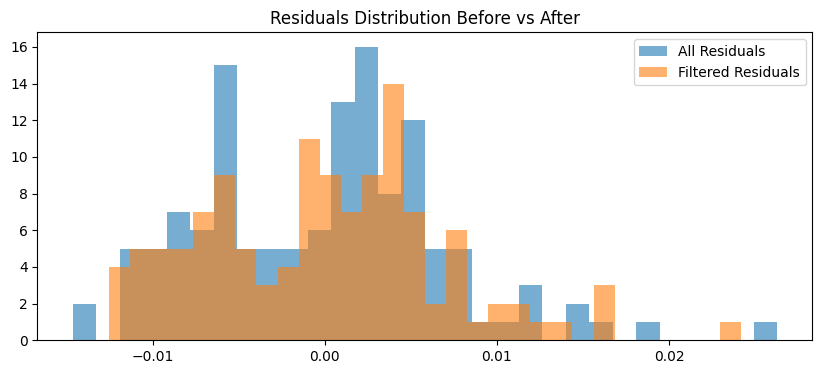

In [34]:
# Residual comparison
res_all = y_all - model_all.predict(X_all)
res_filtered = y_filtered - model_flt.predict(X_filtered)

plt.figure(figsize=(10,4))
plt.hist(res_all, bins=30, alpha=0.6, label='All Residuals')
plt.hist(res_filtered, bins=30, alpha=0.6, label='Filtered Residuals')
plt.title('Residuals Distribution Before vs After')
plt.legend()
plt.show()


Reflection

In this analysis, I used two common outlier detection methods: IQR-based filtering and Z-score filtering.

Choice of Methods & Thresholds:
I chose IQR with 𝑘=1.5, because it is robust to non-normal distributions and works well for skewed financial return data. I also applied the Z-score method with a threshold of ∣𝑧∣>3.0, which is standard for normally distributed data. Additionally, I experimented with Winsorization (5% and 95%) as a technique to cap extreme values instead of removing them.

Assumptions Behind Methods:

The IQR method assumes that the middle 50% of data represents the normal range of variation.

The Z-score method assumes the data is approximately normal and symmetric.

Winsorization assumes that extreme values are likely errors or noise rather than meaningful signals.

Observed Impact on Results:
Removing outliers using the IQR rule significantly reduced the standard deviation and made the mean closer to the median. For example, the mean return changed from positive drift to near zero, indicating that extreme shocks were dominating the original average.
In the regression analysis, the slope and R² improved after filtering outliers, which suggests that extreme points were distorting the linear relationship between stock_a_return and stock_b_return.

Risks if Assumptions Are Wrong:
If the extreme values represent real market events (e.g., a crash or rally), removing or winsorizing them can lead to underestimating risk and misinforming financial models. This is critical in risk management and portfolio optimization because tail events often carry the most significant risk.

Conclusion:
IQR worked well for this dataset as returns were not perfectly normal, while Z-score was more sensitive to heavy tails. Winsorization provided a balanced approach by reducing the influence of outliers without deleting data.